Seek his will in all you do, and he will show you which path to take.
Proverbs 3:6

simulate QAOA to verify the partitioning of neurons by cortical depth.


## Data Loading

In [1]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats, signal
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from scipy.stats import binomtest, binned_statistic 
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score  
from sklearn.metrics import silhouette_score
import networkx as nx
from tqdm import tqdm
import pickle

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Import custom modules
from pathlib import Path
import sys
PROJECT_ROOT = Path().resolve().parents[1]  
sys.path.insert(0, str(PROJECT_ROOT))

from src.dataio.config import DATA_DIR, FILESYSTEM_CONFIG
from src.dataio.data_structures import SessionData
from src.dataio.loaders import load_session_complete
from src.dataio.processors import ResponseProcessor, NetworkAnalyzer, DimensionalityReducer
from src.dataio.validators import validate_session_comprehensive, analyze_session_quality
from src import features

📁 Data directory: /Volumes/pack/qbraid/neuroscience-qaoa/notebooks/simul/data
✓ Data directory exists: True


In [2]:
DATA_DIR = Path('../../data/raw')

# Find all subdirs that contain the expected .mat file
MAT_FILENAME = 'allPlanesVariables27-Feb-2021.mat'
sessions = sorted([
    d.name
    for d in DATA_DIR.iterdir()
    if d.is_dir() and (d / MAT_FILENAME).is_file()
])

print(f"Discovered {len(sessions)} sessions:")
for s in sessions:
    print("  ", s)

# Choose your primary session here (must be one of the discovered names)
PRIMARY_SESSION = '081820_355n'
if PRIMARY_SESSION not in sessions:
    raise ValueError(f"Primary session '{PRIMARY_SESSION}' not found in data/. Available: {sessions}")

print(f"\nPrimary analysis session: {PRIMARY_SESSION}")

# --- now load & process as before ---

session_path = DATA_DIR / PRIMARY_SESSION
print(f"Loading session from: {session_path}")

session = load_session_complete(session_path, use_cache=True)

validation_result = validate_session_comprehensive(session)
quality_report     = analyze_session_quality(session)

print(f"\nSession loaded successfully!")
print(f"Neurons: {len(session.neurons)}")
print(f"Trials:  {len(session.trials)}")
print(f"Activity matrix shape: {session.activity_matrix.shape}")
print(f"Data quality score: {quality_report['overall_score']:.2f}")


Discovered 9 sessions:
   031020_367n_100um20st_FRA
   031020_367r_100um20st_FRA
   031120_352ll_100um20st_FRA
   031120_352ll_100um20st_FRA_diffxy
   080720_400r
   081820_355n
   081920_355l
   081920_355r
   082620_355l

Primary analysis session: 081820_355n
Loading session from: ../../data/raw/081820_355n


VALIDATION WARNING: Unexpected trial count: 22. Expected one of [90, 180]
VALIDATION WARNING: Activity matrix contains 4 NaN values (0.00%).



Session loaded successfully!
Neurons: 416
Trials:  22
Activity matrix shape: (416, 2060)
Data quality score: 1.00


## QAOA Simulation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import json

# Import our modules
from src.dataio.loaders import load_session_complete
from src.dataio.validators import validate_session_comprehensive
from src.analysis.metrics import (
    calc_corr_matrix,
    classical_partition,
    compare_partitions,
    depth_stats,
    plot_depth_scatter,
    plot_correlation_matrix
)
from src.qaoa.hamiltonians import from_corr_matrix, save_hamiltonian
from src.qaoa.simulators import (
    build_qaoa_circuit,
    optimize_qaoa,
    run_qaoa_sampling,
    analyze_qaoa_results
)


In [6]:
OUTPUT_DIR = Path('../../data/derived/qaoa_act1')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# -------- main.py (or just paste in a notebook cell) -----------------------
from pathlib import Path
import pickle
from datetime import datetime

from src.dataio.loaders import load_session_complete
from src.dataio.validators import validate_session_comprehensive
from src.analysis.metrics import analyze_session_quality

MAT_FILENAME = "allPlanesVariables27-Feb-2021.mat"


def main(
    primary_session: str = "081820_355n",
    data_dir: str | Path = "../../data/raw",
    use_cache: bool = True,
    force_rebuild_cache: bool = False,
):
    """
    Load a single 2‑photon session, validating and caching the result.

    Parameters
    ----------
    primary_session : str
        Folder name under *data_dir* that contains the MAT file.
    data_dir : str | Path
        Relative or absolute path to the ``data/raw`` directory.
    use_cache : bool
        If True, try to read/write the pickle cache.
    force_rebuild_cache : bool
        Ignore any existing cache and rebuild from the raw MAT file.
    """
    # ------------------------------------------------------------------ paths
    data_dir = Path(data_dir).expanduser().resolve()
    repo_root = data_dir.parents[1]            # ../../ -> repo root
    cache_dir = repo_root / "cache"
    cache_dir.mkdir(exist_ok=True)

    cache_path = cache_dir / f"{primary_session}_complete.pkl"
    session_path = data_dir / primary_session

    # ---------------------------------------------------------------- checks
    if not (session_path / MAT_FILENAME).is_file():
        raise FileNotFoundError(
            f"MAT file not found in {session_path!s}; "
            f"expected {MAT_FILENAME}"
        )

    # -------------------------------------------------------------- load‑or‑build
    if use_cache and cache_path.is_file() and not force_rebuild_cache:
        try:
            print(f"🗂  Loading cached session from {cache_path.relative_to(repo_root)}")
            with cache_path.open("rb") as f:
                session = pickle.load(f)
        except Exception as e:
            print(f"⚠️  Cache invalid ({e.__class__.__name__}: {e}); rebuilding …")
            session = load_session_complete(session_path, use_cache=False)
    else:
        print("🔄  Building session from raw MAT file …")
        session = load_session_complete(session_path, use_cache=False)

    # --------------------------------------------------------------- re‑cache
    if use_cache and (force_rebuild_cache or not cache_path.is_file()):
        try:
            with cache_path.open("wb") as f:
                pickle.dump(session, f, protocol=pickle.HIGHEST_PROTOCOL)
            ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f"💾  Wrote fresh cache ({ts}) → {cache_path.relative_to(repo_root)}")
        except Exception as e:
            print(f"⚠️  Couldn’t write cache: {e!r} (continuing without it)")

    # -------------------------------------------------------------- validate / QC
    validation_result = validate_session_comprehensive(session)
    quality_report = analyze_session_quality(session)

    # --------------------------------------------------------------- summary
    print("\n✅  Session loaded successfully!")
    print(f" • Neurons:           {len(session.neurons)}")
    print(f" • Trials:            {len(session.trials)}")
    print(f" • Activity matrix:   {session.activity_matrix.shape}")
    print(f" • Data‑quality score {quality_report['overall_score']:.2f}")

    return session, validation_result, quality_report


# Convenience entry‑point when running as a script
if __name__ == "__main__":
    main()


VALIDATION WARNING: Unexpected trial count: 22. Expected one of [90, 180]
VALIDATION WARNING: Activity matrix contains 4 NaN values (0.00%).


🗂  Loading cached session from cache/081820_355n_complete.pkl

✅  Session loaded successfully!
 • Neurons:           416
 • Trials:            22
 • Activity matrix:   (416, 2060)
 • Data‑quality score 0.32


### ACT 1

#### Data loading

\nCoordinate statistics:
X range: 12.0 to 328.2 μm
Y range: 54.4 to 279.9 μm
Z range: -94.5 to -29.1 μm (depth)


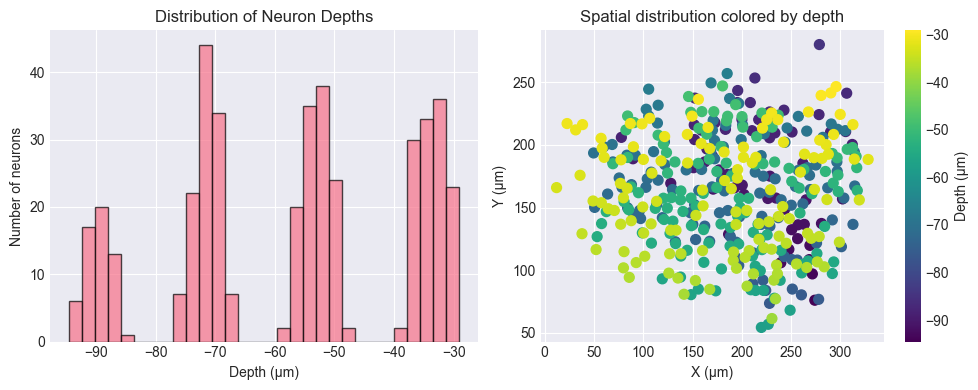

\nCalculating correlation matrix...


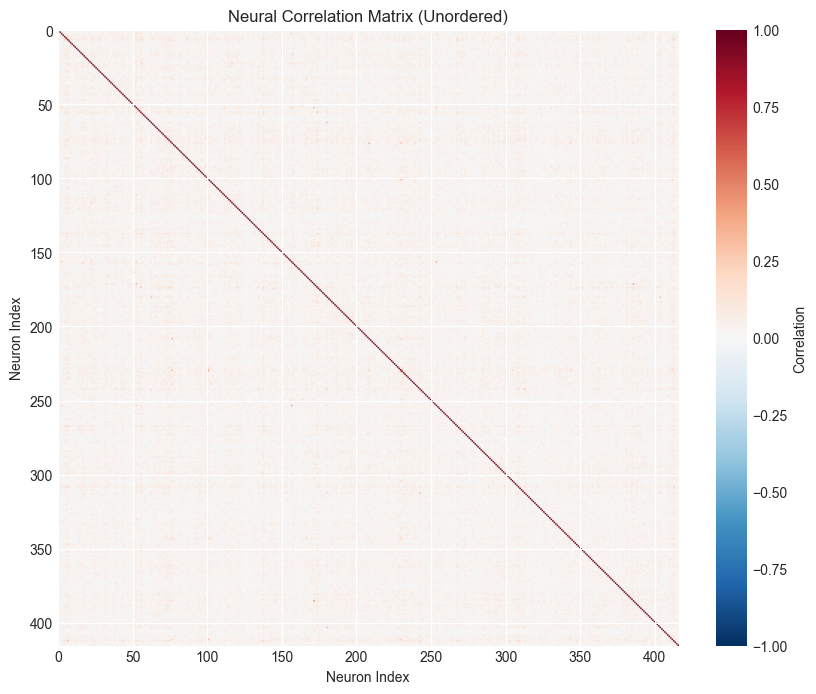

\nCorrelation statistics:
Mean correlation: 0.026
Std correlation: 0.027
Min correlation: -0.087
Max correlation: 0.466


In [7]:
#extract 3d coordinates
coords_3d = np.array([neuron.coords_3d for neuron in session.neurons])
coords_z = coords_3d[:, 2]  # Z-coordinate represents cortical depth

print(f"\\nCoordinate statistics:")
print(f"X range: {coords_3d[:, 0].min():.1f} to {coords_3d[:, 0].max():.1f} μm")
print(f"Y range: {coords_3d[:, 1].min():.1f} to {coords_3d[:, 1].max():.1f} μm")
print(f"Z range: {coords_z.min():.1f} to {coords_z.max():.1f} μm (depth)")

# Visualize depth distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(coords_z, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Depth (μm)')
plt.ylabel('Number of neurons')
plt.title('Distribution of Neuron Depths')

plt.subplot(1, 2, 2)
plt.scatter(coords_3d[:, 0], coords_3d[:, 1], c=coords_z, cmap='viridis', s=50)
plt.colorbar(label='Depth (μm)')
plt.xlabel('X (μm)')
plt.ylabel('Y (μm)')
plt.title('Spatial distribution colored by depth')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'depth_distribution.png', dpi=300)
plt.show()

# %% Calculate correlation matrix
print("\\nCalculating correlation matrix...")
corr_matrix = calc_corr_matrix(session.activity_matrix)

# Save for later use
np.save(OUTPUT_DIR / 'correlation_matrix.npy', corr_matrix)

# Visualize correlation matrix
fig = plot_correlation_matrix(
    corr_matrix, 
    title="Neural Correlation Matrix (Unordered)",
    save_path=OUTPUT_DIR / 'correlation_matrix_unordered.png'
)
plt.show()

# Show correlation statistics
corr_flat = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
print(f"\\nCorrelation statistics:")
print(f"Mean correlation: {np.mean(corr_flat):.3f}")
print(f"Std correlation: {np.std(corr_flat):.3f}")
print(f"Min correlation: {np.min(corr_flat):.3f}")
print(f"Max correlation: {np.max(corr_flat):.3f}")

\nRunning hierarchical clustering...
\nClassical clustering results:
\ngroup_0:
  Count: 13 neurons (3.1%)
  Mean depth: -51.6 ± 15.5 μm
  Depth range: [-73.0, -30.7] μm
\ngroup_1:
  Count: 403 neurons (96.9%)
  Mean depth: -57.4 ± 19.4 μm
  Depth range: [-94.5, -29.1] μm
\nDepth separation between groups:
  Mean difference: 5.9 μm
  Effect size (Cohen's d): 0.33


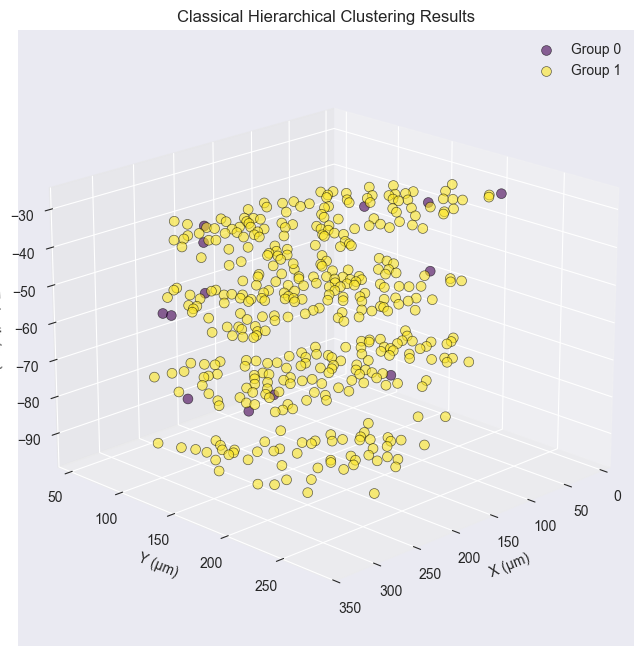

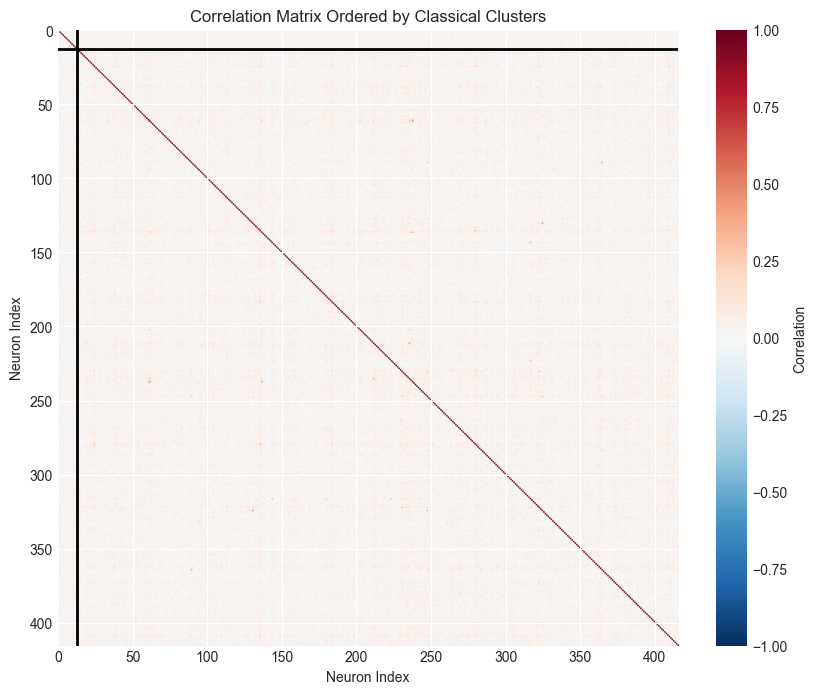

In [8]:
print("\\nRunning hierarchical clustering...")
labels_classical = classical_partition(corr_matrix)

# Analyze depth statistics
stats_classical = depth_stats(labels_classical, coords_z)

print("\\nClassical clustering results:")
for group_name, stats in stats_classical.items():
    if group_name.startswith('group_'):
        print(f"\\n{group_name}:")
        print(f"  Count: {stats['count']} neurons ({stats['fraction']:.1%})")
        print(f"  Mean depth: {stats['mean_depth']:.1f} ± {stats['std_depth']:.1f} μm")
        print(f"  Depth range: [{stats['min_depth']:.1f}, {stats['max_depth']:.1f}] μm")

if 'separation' in stats_classical:
    print(f"\\nDepth separation between groups:")
    print(f"  Mean difference: {stats_classical['separation']['mean_difference']:.1f} μm")
    print(f"  Effect size (Cohen's d): {stats_classical['separation']['effect_size']:.2f}")

# Visualize classical results
fig = plot_depth_scatter(
    coords_3d, labels_classical,
    title="Classical Hierarchical Clustering Results",
    save_path=OUTPUT_DIR / 'classical_partition_3d.png'
)
plt.show()

# Plot ordered correlation matrix
fig = plot_correlation_matrix(
    corr_matrix, labels=labels_classical,
    title="Correlation Matrix Ordered by Classical Clusters",
    save_path=OUTPUT_DIR / 'correlation_matrix_classical_ordered.png'
)
plt.show()